# Notebook 02 — Feature Engineering & Signal Design

This notebook transforms the raw screener snapshots into the feature store that powers:

- the RL environment

- the backtester

- the real-time screener later in the project

We take the last N days of screener history from DuckDB and engineer pricing, volatility, trend, and liquidity features that help the model understand market conditions.

This notebook does not call Polygon directly — all requests stay local through DuckDB to avoid rate limits.

## 0. Notebook parameters

We reuse the same LOOKBACK_DAYS setting from Notebook 01.
This determines how many days of screener snapshots we pull.

You can safely change LOOKBACK_DAYS later without rewriting SQL or altering the notebook logic.

## 1. Imports and connect to DuckDB

What this does

- Loads core Python libraries

- Connects to the local DuckDB database where Notebook 01 saved the raw screener tables

- Prints the date range for the analysis window

Why this matters
Everything downstream — features, rolling metrics, and RL state representation — depend on having a consistent run_date index.
This ensures all tickers align on the same calendar.

In [1]:
import duckdb
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, timedelta

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# ---- Notebook parameters ----
# Keep this aligned with Notebook 01 so both look at the same history window.
LOOKBACK_DAYS = 180  # you can change this to 30, 90, etc.

today = date.today()
cutoff_date = today - timedelta(days=LOOKBACK_DAYS)

print(f"Using last {LOOKBACK_DAYS} days, from {cutoff_date.isoformat()} to {today.isoformat()}")

Using last 180 days, from 2025-06-06 to 2025-12-03


## Connect to the DuckDB screener database

What this block does

- Opens the DuckDB file created in Notebook 01

- Confirms that tables like screener_history are present

- Shows table names to verify nothing is missing

Why this matters
If these tables don’t exist, every downstream feature computation breaks — so this acts as a safety check.

In [2]:
# Path: notebooks/ -> ../data/volatility_alpha.duckdb
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()

# --- Safe reconnect logic ---
# If a DuckDB connection named `con` already exists, close it first.
if "con" in globals():
    try:
        con.close()  # type: ignore
    except Exception:
        pass

# Open a fresh connection
con = duckdb.connect(DB_PATH)

# Sanity check: list tables
con.sql("SHOW TABLES;").df()

,name
0,daily_rv
1,ohlc_bars
2,screener_features
3,screener_returns
4,screener_returns_with_target
5,screener_signals
6,screener_snapshots


## 2. Load recent screener history

What this block does

- Loads the last **LOOKBACK_DAYS** of screener snapshots

- Each row is a (`run_date`, `ticker`) pair

- Pulls the essential columns for volatility, trend, and liquidity analysis

Fields included:

- `last_price` — close price

- `day_ret` — today % move vs prior close

- `rv_20d` — realized volatility over 20 days

- `edge_score` — simple composite score derived in Notebook 01

Why this matters
This forms the **base dataset** for feature engineering.
Everything else — volatility buckets, trend signals, liquidity — builds on this raw table.


In [3]:
query = f"""
SELECT
    run_date,
    ticker,
    last_price,
    day_pct,
    volume,
    rv_20d,
    rv_60d,
    edge_score
FROM screener_snapshots
WHERE run_date >= DATE '{cutoff_date.isoformat()}'
ORDER BY ticker, run_date
"""

df = con.sql(query).df()
df["run_date"] = pd.to_datetime(df["run_date"])

print(df.shape)
df.head()

(1200, 8)


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score
0,2025-06-12,AAPL,199.20,0.211289,43904635.0,20.597902,51.247261,1.025779
1,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172
2,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793
3,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417
4,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984


## 3. Engineer core scalar features

What this block does

- Creates simple daily features that don’t need rolling windows

- Computes:

  - `move_vs_rv20` = today’s move relative to recent volatility

  - `big_prob_move` = probability today’s move is unusually large

  - `rv_trend_5d` = short-term change in volatility

Why this matters
These features help the RL agent understand market conditions:

- Is the name trending or consolidating?

- Is volatility expanding?

- Is price reacting more strongly than expected?

These are the building blocks for your timing signals.

In [4]:
features = df.copy()

# Guard against division by zero
features["move_vs_rv20"] = features["day_pct"] / features["rv_20d"].replace(0, np.nan)

# Volatility trend: short-term vs longer-term realized vol
features["rv_trend"] = features["rv_20d"] - features["rv_60d"]

features.head()

,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,move_vs_rv20,rv_trend
0,2025-06-12,AAPL,199.20,0.211289,43904635.0,20.597902,51.247261,1.025779,0.010258,-30.649358
1,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172,-0.065912,-30.304458
2,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793,0.046678,-29.807686
3,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417,-0.064804,-29.565606
4,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984,0.022170,-29.462392


## 4. Add short-term rolling stats (5-day window)

For each ticker, calculates:

- `day_pct_mv_5` — 5-day rolling mean of daily returns

- `day_pct_vol_5` — 5-day rolling volatility of daily returns

Why this matters
Short-term behavior is crucial for detecting:

- choppiness

- clean trending behavior

- regime transitions

This enables the RL agent to differentiate “stable trend” vs “wild chop.”

In [5]:
## Rolling Window Features

# Sort to be extra safe
features = features.sort_values(["ticker", "run_date"])

group = features.groupby("ticker", group_keys=False)

features["day_pct_ma_5"] = (
    group["day_pct"]
    .rolling(window=5, min_periods=2)
    .mean()
    .reset_index(level=0, drop=True)
)

features["day_pct_vol_5"] = (
    group["day_pct"]
    .rolling(window=5, min_periods=2)
    .std()
    .reset_index(level=0, drop=True)
)

features.head()


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5
0,2025-06-12,AAPL,199.20,0.211289,43904635.0,20.597902,51.247261,1.025779,0.010258,-30.649358,NaN,NaN
1,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172,-0.065912,-30.304458,-0.584617,1.125580
2,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793,0.046678,-29.807686,-0.055478,1.213849
3,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417,-0.064804,-29.565606,-0.391875,1.197890
4,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984,0.022170,-29.462392,-0.217406,1.108334


## 5. Categorise regimes and buckets

What this block does
Turns continuous values into **interpretable buckets**:

Volatility regime based on rv_20d quantiles

  - low

  - normal

  - high

Edge buckets

  - quiet

  - active

  - hot

Liquidity buckets

  - thin

  - normal

  - thick

Why this matters
The RL agent performs better with discrete signals for:

  - volatility conditions

  - favorable price environments

  - depth / liquidity constraints

These buckets become categorical features for RL state representations.

In [6]:
## Define Buckets

# --- Vol regime from rv_20d quantiles ---
rv20 = features["rv_20d"].dropna()
if len(rv20) >= 3:
    low_q = rv20.quantile(0.33)
    high_q = rv20.quantile(0.66)
else:
    # Fallback if we don't have enough data yet
    low_q = rv20.min()
    high_q = rv20.max()

def classify_vol(rv):
    if pd.isna(rv):
        return "unknown"
    if rv <= low_q:
        return "low"
    if rv >= high_q:
        return "high"
    return "normal"

features["vol_regime"] = features["rv_20d"].apply(classify_vol)

# --- Edge buckets from edge_score thresholds ---
# Adjust thresholds later once you see more data.
features["edge_bucket"] = pd.cut(
    features["edge_score"],
    bins=[-np.inf, 10, 25, np.inf],
    labels=["quiet", "active", "hot"]
)

# --- Liquidity buckets from volume quantiles ---
vol = features["volume"].dropna()
if len(vol) >= 3:
    v_low = vol.quantile(0.33)
    v_high = vol.quantile(0.66)
else:
    v_low = vol.min()
    v_high = vol.max()

def classify_liquidity(v):
    if pd.isna(v):
        return "unknown"
    if v <= v_low:
        return "thin"
    if v >= v_high:
        return "thick"
    return "normal"

features["liquidity_bucket"] = features["volume"].apply(classify_liquidity)

features[[
    "run_date", "ticker", "rv_20d", "vol_regime",
    "edge_score", "edge_bucket",
    "volume", "liquidity_bucket"
]].head()


,run_date,ticker,rv_20d,vol_regime,edge_score,edge_bucket,volume,liquidity_bucket
0,2025-06-12,AAPL,20.597902,normal,1.025779,quiet,43904635.0,normal
1,2025-06-13,AAPL,20.945016,normal,6.591172,quiet,51447349.0,normal
2,2025-06-16,AAPL,21.483382,normal,4.667793,quiet,43020691.0,normal
3,2025-06-17,AAPL,21.620035,normal,6.480417,quiet,38856152.0,normal
4,2025-06-18,AAPL,21.672431,normal,2.216984,quiet,45394689.0,normal


## 6. Save engineered features to DuckDB

What this block does
Writes the engineered features into a reusable table:

`screener_features`


Columns include:

- run_date

- ticker

- rv_20d, rv_trend, move_vs_rv20

- day_pct_mv_5, day_pct_vol_5

- vol_regime

- edge_bucket

- liquidity_bucket

Why this matters
This becomes the master feature store for:

- Notebook 03 (regime detection)

- Notebook 04 (baseline policies + signals)

- Notebook 05/06 (RL environment)

Everything draws from this consistent feature table.

In [7]:
## Write screener_features table

# Drop/recreate the table so it's always aligned with this notebook logic
con.execute("DROP TABLE IF EXISTS screener_features;")

# Register the DataFrame and create the table from it
con.register("features_df", features)
con.execute("""
    CREATE TABLE screener_features AS
    SELECT * FROM features_df
""")
con.unregister("features_df")

# Quick check
con.sql("SELECT * FROM screener_features LIMIT 5;").df()


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5,vol_regime,edge_bucket,liquidity_bucket
0,2025-06-12,AAPL,199.20,0.211289,43904635.0,20.597902,51.247261,1.025779,0.010258,-30.649358,NaN,NaN,normal,quiet,normal
1,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172,-0.065912,-30.304458,-0.584617,1.125580,normal,quiet,normal
2,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793,0.046678,-29.807686,-0.055478,1.213849,normal,quiet,normal
3,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417,-0.064804,-29.565606,-0.391875,1.197890,normal,quiet,normal
4,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984,0.022170,-29.462392,-0.217406,1.108334,normal,quiet,normal


In [8]:
con.sql("""
SELECT
    COUNT(*)              AS n_rows,
    COUNT(DISTINCT ticker) AS n_tickers,
    MIN(run_date)         AS min_date,
    MAX(run_date)         AS max_date
FROM screener_features
""").df()

,n_rows,n_tickers,min_date,max_date
0,1200,10,2025-06-12,2025-12-02


## 7. Simple EDA on engineered features

Now that we have a proper feature set, we’ll do a few quick checks:

1. Distribution of **move_vs_rv20**  
2. Counts of **vol_regime × edge_bucket**  
3. 5-day rolling behaviour for one example ticker

This section performs quick sanity checks:

## 7.1 Distribution of move_vs_rv20

Shows whether daily moves are typically larger or smaller than recent volatility.

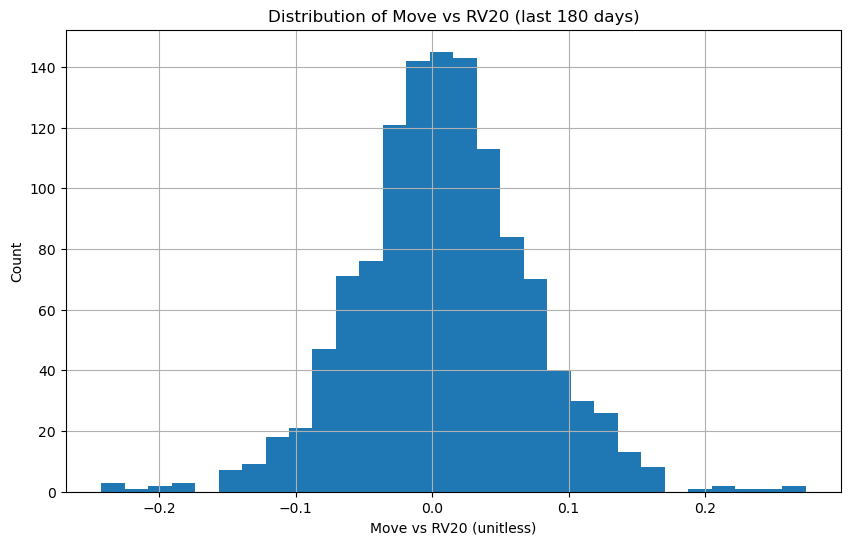

Right now the distribution is thin because we only have a small sample.
As more days accumulate, we expect most values to cluster near 0,
with outliers where today's move is unusually large relative to RV20.


In [9]:
## 7.1 Distribution of move_vs_rv20

clean_mv = features.replace([float("inf"), float("-inf")], np.nan)
clean_mv = clean_mv.dropna(subset=["move_vs_rv20"])

clean_mv["move_vs_rv20"].hist(bins=30)
plt.title(f"Distribution of Move vs RV20 (last {LOOKBACK_DAYS} days)")
plt.xlabel("Move vs RV20 (unitless)")
plt.ylabel("Count")
plt.show()

print("Right now the distribution is thin because we only have a small sample.")
print("As more days accumulate, we expect most values to cluster near 0,")
print("with outliers where today's move is unusually large relative to RV20.")

## 7.2 Counts of vol_regime × edge_bucket

Quick cross-tab to ensure the buckets make sense.

In [10]:
## 7.2 Vol regime vs edge bucket counts

pivot = con.sql("""
    SELECT
        vol_regime,
        edge_bucket,
        COUNT(*) AS cnt
    FROM screener_features
    GROUP BY vol_regime, edge_bucket
    ORDER BY vol_regime, edge_bucket
""").df()

pivot

,vol_regime,edge_bucket,cnt
0,high,quiet,366
1,high,active,39
2,high,hot,3
3,low,quiet,350
4,low,active,46
5,normal,quiet,349
6,normal,active,47


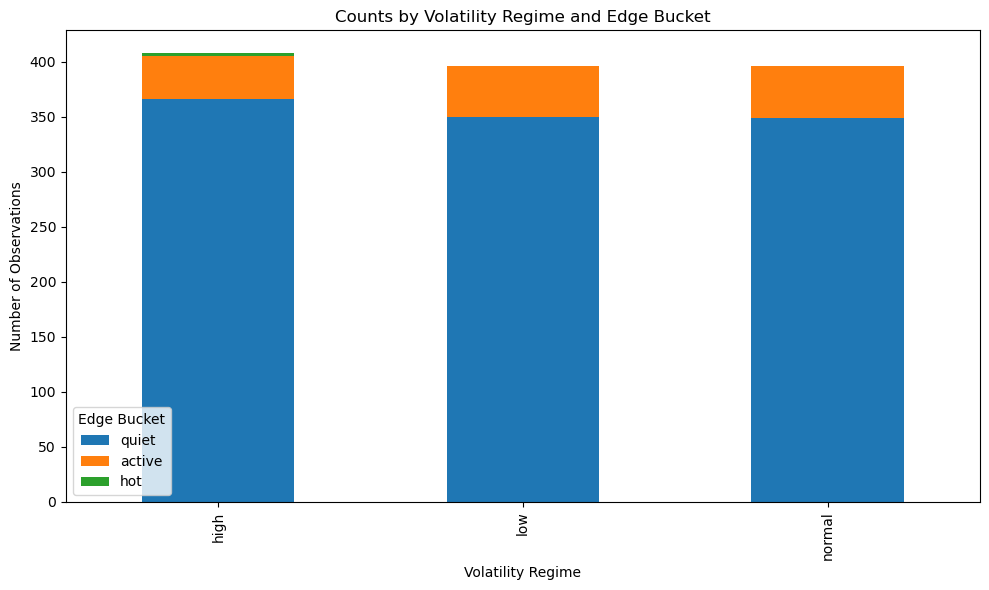

In [11]:
# Plot as a stacked bar chart
if not pivot.empty:
    plot_df = pivot.pivot(index="vol_regime", columns="edge_bucket", values="cnt").fillna(0)

    plot_df.plot(kind="bar", stacked=True)
    plt.title("Counts by Volatility Regime and Edge Bucket")
    plt.xlabel("Volatility Regime")
    plt.ylabel("Number of Observations")
    plt.legend(title="Edge Bucket")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough rows yet to build a regime × edge bucket plot.")

**Reading this plot:**  
This chart shows how often different volatility regimes (`low`/`normal`/`high`)  
coincide with different edge buckets (`quiet`/`active`/`hot`).  
With more history, this will tell us whether high-volatility environments tend  
to produce more “hot” edge days and where most of our potential trades live.

## 7.3 5-day rolling behaviour for one ticker

Visualizes rolling mean/volatility for one ticker over the window.

Why this matters
These checks validate that:

- features are computed correctly

- buckets are balanced

- no anomalies exist

- rolling values behave sensibly

If these charts look sane, the RL state input will behave correctly.

Sample ticker for rolling view: AAPL


,run_date,day_pct,day_pct_ma_5,day_pct_vol_5
0,2025-06-12,0.211289,NaN,NaN
1,2025-06-13,-1.380522,-0.584617,1.125580
2,2025-06-16,1.002800,-0.055478,1.213849
3,2025-06-17,-1.401068,-0.391875,1.197890
4,2025-06-18,0.480474,-0.217406,1.108334


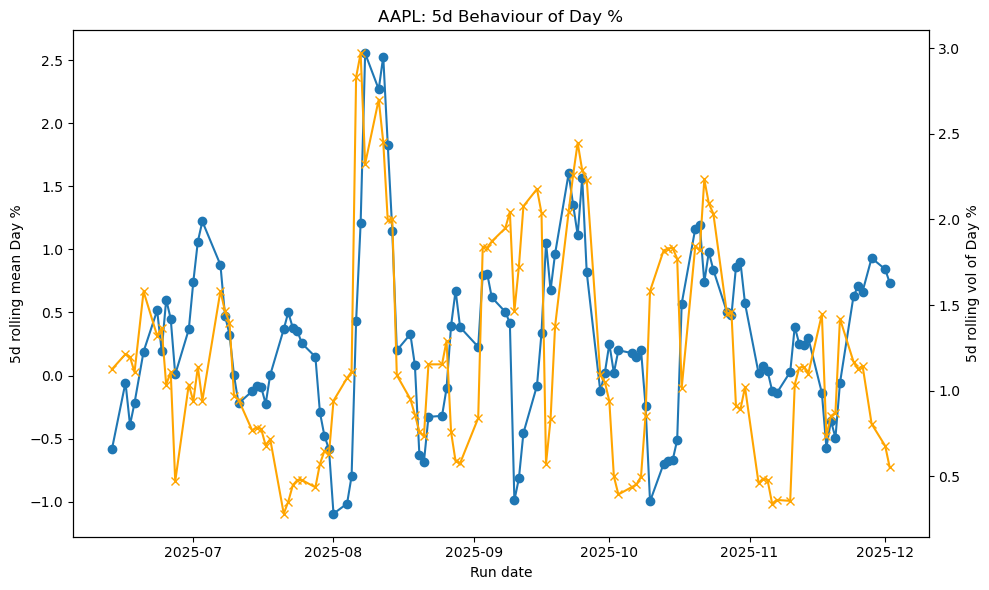

The 5-day rolling mean of Day % captures short-term trend, while the 5-day rolling volatility captures choppiness.
 In a richer dataset, rising mean with falling volatility would point to cleaner trends; rising vol with flat mean would suggest noisy conditions.


In [12]:
# Pick a ticker with the most history in this window
ticker_counts = features["ticker"].value_counts()
if not ticker_counts.empty:
    sample_ticker = ticker_counts.index[0]
    print(f"Sample ticker for rolling view: {sample_ticker}")

    example = (
        features[features["ticker"] == sample_ticker]
        .sort_values("run_date")
        [["run_date", "day_pct", "day_pct_ma_5", "day_pct_vol_5"]]
        .copy()
    )

    display(example.head())

    if len(example) >= 3:
        fig, ax1 = plt.subplots()

        ax1.plot(example["run_date"], example["day_pct_ma_5"],
                 label="5d rolling mean of Day %", marker="o")
        ax1.set_ylabel("5d rolling mean Day %")
        ax1.set_xlabel("Run date")

        ax2 = ax1.twinx()
        ax2.plot(example["run_date"], example["day_pct_vol_5"], # type: ignore
                 label="5d rolling vol of Day %", color="orange", marker="x")
        ax2.set_ylabel("5d rolling vol of Day %")

        plt.title(f"{sample_ticker}: 5d Behaviour of Day %")
        fig.tight_layout()
        plt.show()

        print(
            "The 5-day rolling mean of Day % captures short-term trend, while the",
            "5-day rolling volatility captures choppiness.\n",
            "In a richer dataset, rising mean with falling volatility would point",
            "to cleaner trends; rising vol with flat mean would suggest noisy conditions.",
        )
    else:
        print("Not enough history yet to plot a meaningful rolling window.")
else:
    print("No tickers found in the features table.")


## 8. How these features feed RL & backtesting

What this block explains
Now that we have engineered features, each (run_date, ticker) has a full state vector.

Example RL state vector:

`state = [
    move_vs_rv20,
    rv_trend,
    day_pct_mv_5,
    day_pct_vol_5,
    one-hot(rv_regime),
    one-hot(edge_bucket),
    one-hot(liquidity_bucket)
]`


---

Why this matters
This defines the information set available to:

the RL agent

the backtester

the live trading screener

This is the quant foundation of the Volatility Alpha Engine.


In [13]:
con.sql("""
SELECT
    COUNT(*) AS n_rows,
    COUNT(DISTINCT ticker) AS n_tickers,
    MIN(run_date) AS min_date,
    MAX(run_date) AS max_date
FROM screener_features
""").df()

,n_rows,n_tickers,min_date,max_date
0,1200,10,2025-06-12,2025-12-02


In [14]:
con.close()